In [1]:
import numpy as np
from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor
import scipy.io
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# colors:
dark = np.array([51.0, 51.0, 51.0]) / 255.0
red = np.array([141.0, 45.0, 57.0]) / 255.0
gold = np.array([174.0, 159.0, 109.0]) / 255.0
gray = np.array([175.0, 179.0, 183.0]) / 255.0
lred = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - red)
lgold = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - gold)

Here's our old parametric code: First, the prior.

In [3]:
# first, define the prior
def phi(a):
    ell = 1.0
    return 3 * np.exp(-((a - np.linspace(-8, 8, 16).T) ** 2) / (ell ** 2) / 2.0)


F = len(phi(0))  # number of features
# set parameters of prior on the weights
mu = np.zeros((F, 1))
Sigma = np.eye(F)  # p(w)=N(mu,Sigma)

Then regression.

In [4]:
# construct implied prior on f_x
n = 100  # number of grid-points, for plotting
x = np.linspace(-8, 8, n)[:, np.newaxis]  # reshape is needed for phi to work
m = phi(x) @ mu
kxx = phi(x) @ Sigma @ phi(x).T  # p(f_x)=N(m,k_xx)
s = multivariate_normal(m.flatten(), kxx, size=5).T
stdpi = np.sqrt(np.diag(kxx))[:, np.newaxis]  # marginal stddev, for plotting

# then, load data from disk
data = scipy.io.loadmat("nlindata.mat")
# import scipy.io; data = scipy.io.loadmat('nlindata.mat') # use this line to get the nonlinear data.
X = data["X"]  # inputs
Y = data["Y"]  # outputs
sigma = float(data["sigma"])  # measurement noise std-deviation
N = len(X)  # number of data

# evidence: p(Y) = N(Y;M,kXX + sigma**2 * no.eye(N))
M = phi(X) @ mu
kXX = phi(X) @ Sigma @ phi(X).T  # p(f_X) = N(M,k_XX)
G = kXX + sigma ** 2 * np.eye(N)

# now, do inference (i.e. construct the posterior)
# the following in-place decomposition is the most expensive step at O(N^3):
G = cho_factor(G)
kxX = phi(x) @ Sigma @ phi(X).T  # Cov(f_x,f_X) = k_xX
A = cho_solve(G, kxX.T).T  # pre-compute for re-use (but is only O(N^2))

# # posterior p(f_x|Y) = N(f_x,mpost,vpost)
mpost = m + A @ (Y - M)  # mean
vpost = kxx - A @ kxX.T  # covariance
spost = multivariate_normal(mpost.flatten(), vpost, size=5).T  # samples
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]  # marginal stddev, for plotting

### defining kernel & mean function explicitly from feature functions

Instead, we can first wrap up the prior in a *kernel*:

In [5]:
def m(x):
    return phi(x) @ mu


def k(a, b):
    return phi(a) @ Sigma @ phi(b).T

And rewrite our code from above more succinctly. (Now as a simplistic function, so we can easily call it below

*Note: No more explicit feature functions ($\phi$) used below here!*

In [6]:
def GP_reg(m, k):
    out = {}
    # construct implied prior on f_x
    n = 100  # number of grid-points, for plotting
    # reshape is needed for phi to work
    x = np.linspace(-8, 8, n)[:, np.newaxis]
    out["mx"] = m(x)
    out["kxx"] = k(x, x)  # p(f_x)=N(m,k_xx)
    out["s"] = multivariate_normal(m(x).flatten(), k(x, x), size=5).T
    # marginal stddev, for plotting
    out["stdpi"] = np.sqrt(np.diag(k(x, x)))[:, np.newaxis]

    # then, load data from disk
    data = scipy.io.loadmat("nlindata.mat")
    # import scipy.io; data = scipy.io.loadmat('nlindata.mat') # use this line to get the nonlinear data.
    X = data["X"]  # inputs
    Y = data["Y"]  # outputs
    sigma = float(data["sigma"])  # measurement noise std-deviation
    N = len(X)  # number of data

    # evidence: p(Y) = N(Y;M,kXX + sigma**2 * no.eye(N))
    mX = m(X)
    kXX = k(X, X)  # p(f_X) = N(M,k_XX)
    G = kXX + sigma ** 2 * np.eye(N)

    # now, do inference (i.e. construct the posterior)
    # the following in-place decomposition is the most expensive step at O(N^3):
    G = cho_factor(G)
    kxX = k(x, X)  # Cov(f_x,f_X) = k_xX
    A = cho_solve(G, kxX.T).T  # pre-compute for re-use (but is only O(N^2))

    # # posterior p(f_x|Y) = N(f_x,mpost,vpost)
    out["mpost"] = m(x) + A @ (Y - mX)  # mean
    out["vpost"] = k(x, x) - A @ kxX.T  # covariance
    out["spost"] = multivariate_normal(
        out["mpost"].flatten(), out["vpost"], size=5
    ).T  # samples
    # marginal stddev, for plotting
    out["stdpo"] = np.sqrt(np.diag(out["vpost"]))[:, np.newaxis]

    return out

### plotting:

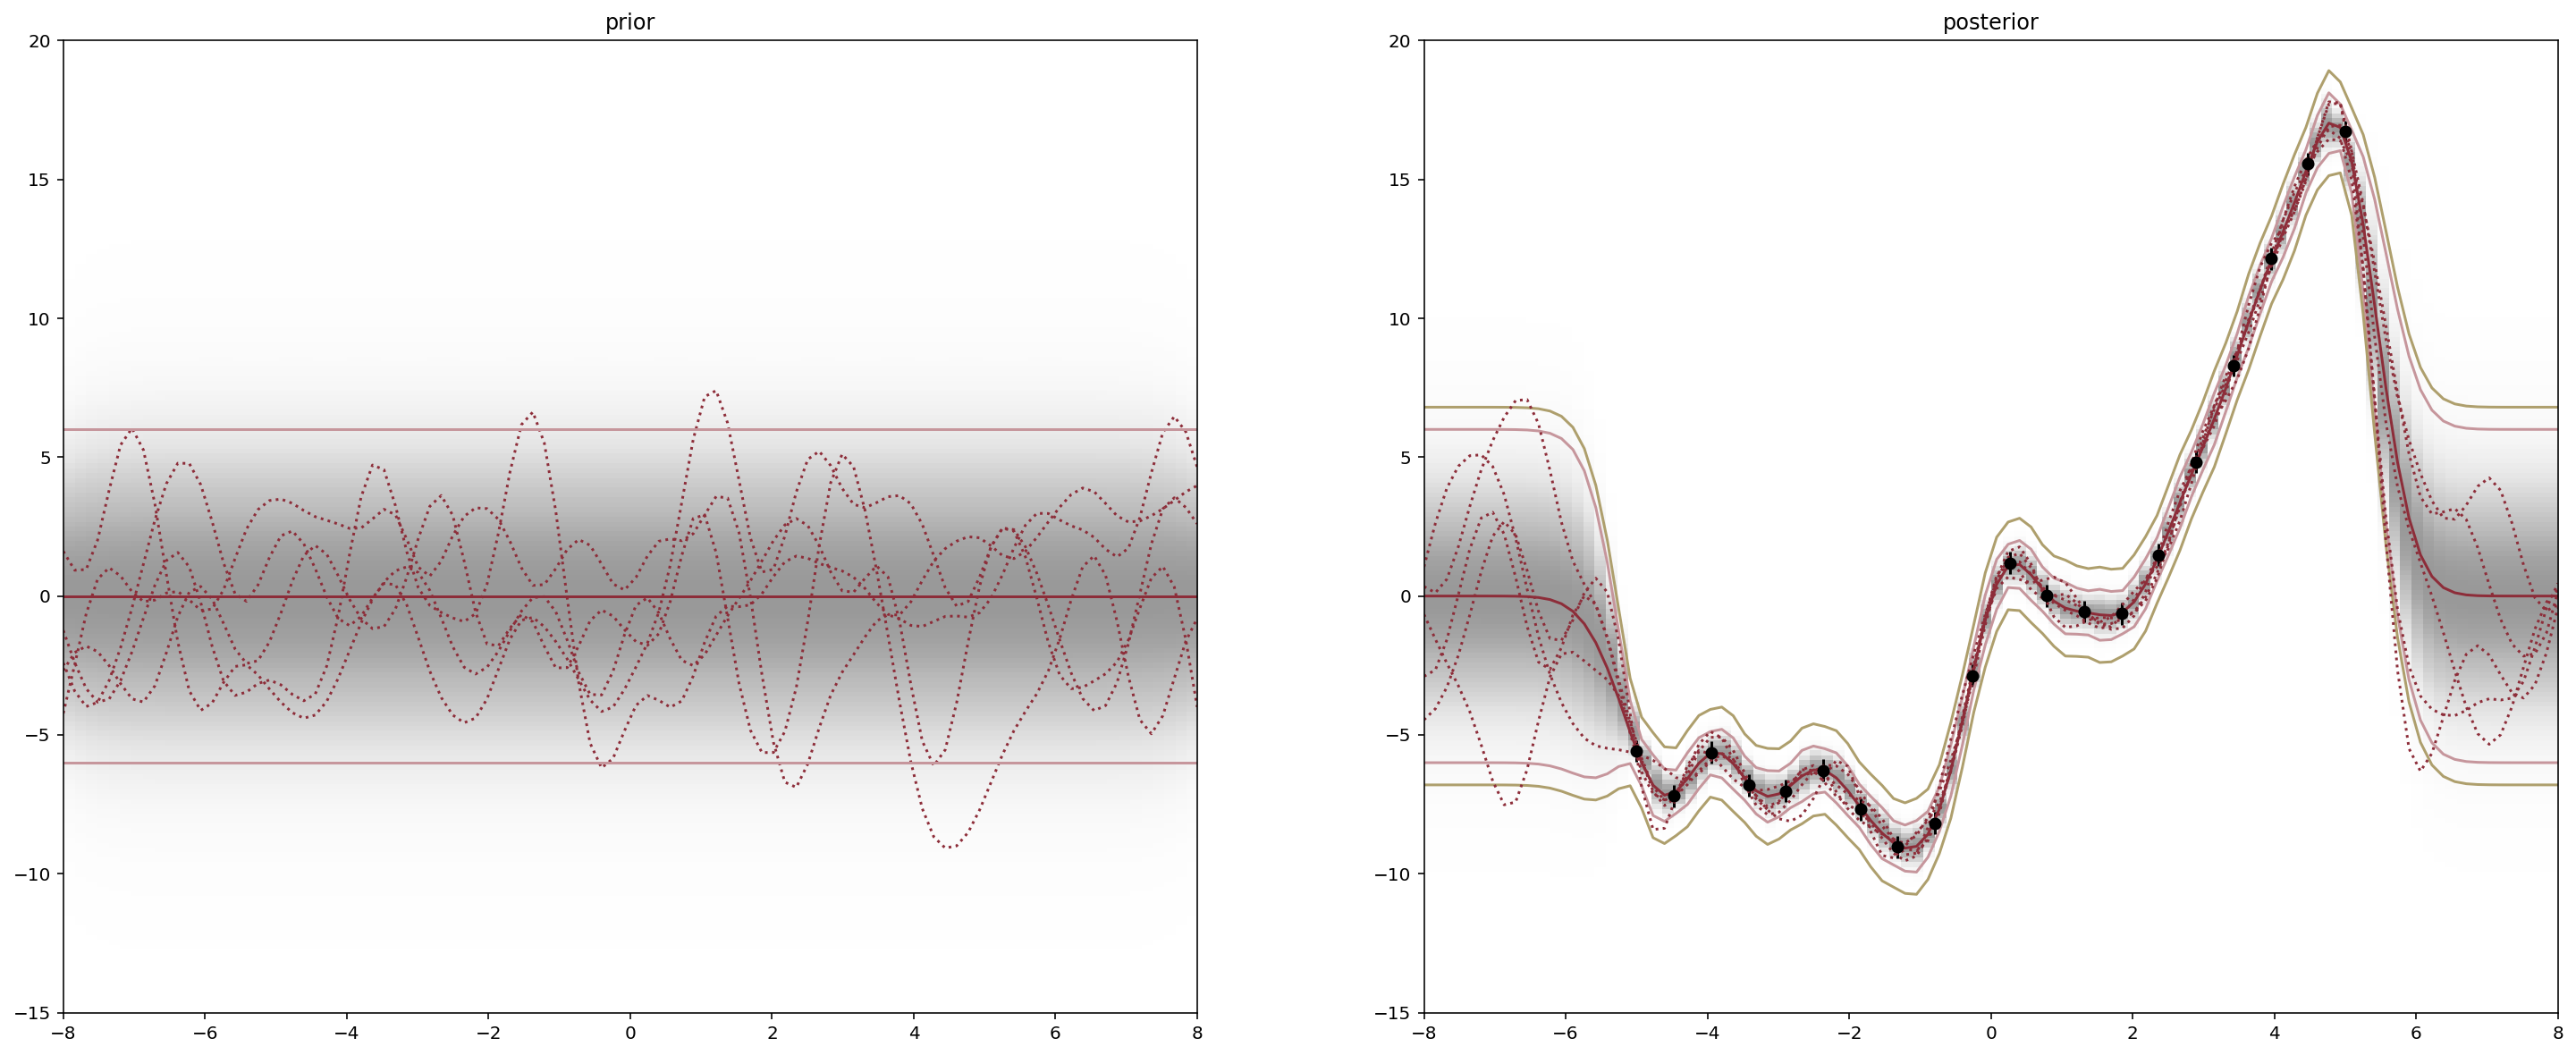

In [10]:
plt.rcParams["figure.figsize"] = (25, 10)
fig, ax = plt.subplots(1, 2)


def GaussPDFscaled(y, m, s):  # shading
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


GPout = GP_reg(m, k)

yy = np.linspace(-15, 20, 200).reshape([200, 1])
P = GaussPDFscaled(yy, GPout["mx"], stdpi)

ax[0].imshow(
    P, extent=[-8, 8, -15, 20], aspect="auto", origin="lower", cmap="Greys", alpha=0.4
)
ax[0].plot(x, GPout["s"], ":", color=red)  # prior
ax[0].plot(x, GPout["mx"], "-", color=red)
ax[0].plot(x, GPout["mx"] + 2 * GPout["stdpi"], "-", color=lred)
ax[0].plot(x, GPout["mx"] - 2 * GPout["stdpi"], "-", color=lred)
ax[0].set(xlim=[-8, 8], ylim=[-15, 20], title="prior")

Ppost = GaussPDFscaled(
    yy, GPout["mpost"], GPout["stdpo"]
)  # shading by local marginal pdf
ax[1].imshow(
    Ppost,
    extent=[-8, 8, -15, 20],
    aspect="auto",
    origin="lower",
    cmap="Greys",
    alpha=0.4,
)
ax[1].errorbar(X, Y, yerr=sigma, fmt="ok")  # data
ax[1].plot(x, GPout["mpost"], "-", color=red)  # posterior mean
ax[1].plot(
    x, GPout["mpost"] + 2 * GPout["stdpo"], "-", color=lred
)  # upper error bars on f
ax[1].plot(
    x, GPout["mpost"] - 2 * GPout["stdpo"], "-", color=lred
)  # lower error bars on f

ax[1].plot(
    x, GPout["mpost"] + 2 * GPout["stdpo"] + 2 * sigma, "-", color=gold
)  # predictive error bars (on y)
ax[1].plot(x, GPout["mpost"] - 2 * GPout["stdpo"] - 2 * sigma, "-", color=gold)

ax[1].plot(x, GPout["spost"], ":", color=red)  # samples
ax[1].set(xlim=[-8, 8], ylim=[-15, 20], title="posterior")

plt.show()

## nonparametric kernels

Abstract definition of kernel, and let's use a zero mean function for simplicity

In [8]:
def m(x):
    return 0.0 * x  # mean function


def kernel(f):
    return lambda a, b: np.array(
        [[np.float64(f(a[i], b[j])) for j in range(b.size)]
         for i in range(a.size)]
    )

Some kernels:

In [9]:
# square exponential kernel:
def SE(a, b, ell):
    return 3 ** 2 * np.exp(-((a - b) ** 2) / 2.0 / ell ** 2)


k = kernel(lambda a, b: SE(a, b, 0.5))

In [34]:
# Wiener process
def Wiener(a, b, c):
    return np.minimum(a - c, b - c)


k = kernel(lambda a, b: Wiener(a, b, -8.1))

In [38]:
# Ornstein Uhlenbeck:
def OU(a, b, ell):
    return 3 ** 2 * np.exp(-np.abs(a - b) / ell ** 2)


k = kernel(lambda a, b: OU(a, b, 3))

In [42]:
# Cubic splines (integrated Wiener / "infinitely wide ReLU")
def spline3(a, b, c, o):
    return c ** 2 * (
        np.minimum(a - o, b - o) ** 3 / 3.0
        + 0.5 * np.abs(a - b) * np.minimum(a - o, b - o) ** 2
    )


k = kernel(lambda a, b: spline3(a, b, 1, -9.0))

In [48]:
# linear
def linear(a, b):
    return a * b


k = kernel(linear)

In [44]:
# kernels of maps are kernels
def phi(a):
    return ((a + 8.1) / 4) ** 2


k = kernel(lambda a, b: SE(phi(a), phi(b), 1))

In [49]:
# sums of kernels are kernels
k = kernel(lambda a, b: linear(a, b) + SE(a, b, 1))

In [52]:
# product of kernels is a kernel
k = kernel(lambda a, b: linear(a, b) * SE(a, b, 1))